In [1]:
import os
import sys
sys.path.insert(0, "../name-package/")
from io import StringIO
import requests
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
from measure import MAE, MAPE
from sklearn.preprocessing import MinMaxScaler
from tcn import TCN
from tensorflow.keras import Input, Model, Sequential, layers, metrics
my_seed = 2
np.random.seed(my_seed)
import random
random.seed(my_seed)
import tensorflow as tf
tf.random.set_seed(my_seed)

In [2]:
def load_OxCGRT():
    path = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    d = pd.read_csv(path, parse_dates=['Date'], low_memory=False)
    index_cols = ['Country_Region', 'Province_State']
    d.rename(columns={'CountryName': index_cols[0], 'RegionName': index_cols[1]}, inplace=True)
    d[index_cols[0]] = d[[index_cols[0]]].fillna('')
    d[index_cols[1]] = d[[index_cols[1]]].fillna('')
    d['Cases'], d['Deaths'] = d.ConfirmedCases.fillna(0), d.ConfirmedDeaths.fillna(0)
    d['Date'] = pd.to_datetime(d['Date'], format='%m/%d/%y')
    #weekday: Mon=1, Tue=2, ...., Sun=7 
    d["weekday"] = d['Date'].dt.dayofweek + 1    
    d = d.set_index(index_cols+['weekday', 'Date'])   
    return d

In [3]:
def load_mobility():
    orig_url='https://drive.google.com/file/d/1qeoJdMlF9lzwXUmNMWgglozxVoZaR12D/view?usp=sharing'
    file_id = orig_url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
    url = requests.get(dwn_url).text
    csv_raw = StringIO(url)
    d = pd.read_csv(csv_raw, parse_dates=['Date'], low_memory=False)
    d = d.set_index('Date')
    return d

In [4]:
def view_data(d, target, date_col):
    fig = px.line(d[target], x=d.index.get_level_values(date_col), y=target[0], color_discrete_sequence=px.colors.qualitative.Dark2)
    fig.update_layout(xaxis=dict(title='Time (Weekly)'), yaxis=dict(title='Weekly Total '+ target[0]))
    fig.update_traces(mode='markers+lines')
    fig.layout.template = 'plotly_white'
    fig.show()

In [5]:
def Series2Xy(d, target, var, sliding_steps, lookback_steps, gap, output_steps, is_multi_var):
    '''
    Transform the time series to supervised data 
        - d: dataframe
        - target: the target to predict, a 1D list of column name in df, e.g., ['Cases']
        - var: the list of covariates
        - silding_steps: the steps that sliding window moves forward
        - lookback_steps: how many previous steps used, e.g., using X = [1, 2, 3] to predict y = [1, 2], 3 lookback_steps
        - gap: the steps between X and y
        - output_steps: how long the output y is, e.g., y = [1, 2] means 2 output_steps 
        - is_multi_var: if using multivariate or univariate
    '''
    X, y = [], []
    d_target = np.array(d[target])
    for i in range(lookback_steps + (gap - 1) + output_steps, len(d), sliding_steps):
        X_target = d_target[i - lookback_steps - (gap - 1) - output_steps: i - (gap - 1) - output_steps]
        if is_multi_var:
            X_var = np.array(d[var])[i - lookback_steps - (gap - 1) - output_steps: i - (gap - 1) - output_steps]
        else:
            X_var = np.array([], dtype=np.int64).reshape(lookback_steps, 0)
        X.append(np.concatenate((X_var, X_target), axis=1))
        y.append(d_target[i - output_steps + 1:i + 1])
    X = np.array(X)
    y = np.array(y)
    y = y.reshape(y.shape[0], y.shape[1])
    return X, y

In [6]:
def SeriesSplit(d, date_col, train_size, test_size, end_date_of_known_data, sliding_steps, lookback_steps, gap, pred_steps, interval = 1):
    '''
    Split time-series to training and test sets
        - d: dataframe
        - date_col: date column name
        - train_size: the number of training samples
        - test_size: the number of test samples
        - end_date_of_known_data: the last day of known data
        - silding_steps: the steps that sliding window moves forward
        - lookback_steps: how many previous steps used, e.g., using X = [1, 2, 3] to predict y = [1, 2], 3 lookback_steps
        - gap: the steps between X and y
        - pred_steps: the total steps to predict
        - scaler: the normalization method
        - interval: the date interval, default value of 1, taking 7 for in our weekly prediction task
    '''
    sliding_steps, lookback_steps, gap, pred_steps = sliding_steps * interval, lookback_steps * interval, gap * interval, pred_steps * interval
    file_start_date, file_end_date = d.index.get_level_values(date_col).min(), d.index.get_level_values(date_col).max()
    if end_date_of_known_data > file_end_date or end_date_of_known_data < file_start_date:
        end_date_of_known_data = file_end_date
    if test_size <= 0:
        train_end_date = end_date_of_known_data
        d_test = None
    else:
        d_test = d[d.index.get_level_values(date_col) <= end_date_of_known_data]
        test_start_date = d_test.index.get_level_values(date_col).max() - timedelta(lookback_steps + gap + pred_steps - interval) - timedelta((test_size - 1) * sliding_steps)
        train_end_date = test_start_date - timedelta(sliding_steps) + timedelta(lookback_steps + gap + pred_steps - interval)
        d_test = d_test[d_test.index.get_level_values(date_col) >= test_start_date]
    train_start_date = train_end_date - timedelta(lookback_steps + gap + pred_steps - interval) - timedelta((train_size - interval) * sliding_steps)
    if train_start_date < file_start_date:
        train_start_date = file_start_date
    d_train = d[(d.index.get_level_values(date_col) >= train_start_date) & (d.index.get_level_values(date_col) <= train_end_date)]
    return d_train, d_test

In [7]:
def direcursive_predict(models, d, date_col, target, var, lookback_steps, output_steps, pred_steps, is_multi_var, scaler, interval = 1):
    '''
    - d: input data including the input data and dates to predict
    - date_col: date column name
    - target: target numbers
    - var: covariate columns
    - lookback_steps: previous steps used as the input X of the model
    - output_steps: the length of the output y
    - pred_steps: how far future to predict
    - is_multi_var: using multivariate or univariate
    - scaler: the normalization method
    - interval: the date interval, default value of 1, taking 7 for in our weekly prediction task
    '''
    past_target = d.iloc[:lookback_steps][target]
    current_date = d.index.get_level_values(date_col).min() + timedelta((lookback_steps - 1) * interval)
    end_date = current_date + timedelta(pred_steps * interval)
    preds = []
    if is_multi_var:
        future_vars = d[var]
        past_vars = d.iloc[:lookback_steps][var]
        days_ahead = lookback_steps
        while current_date < end_date:
            X_vars = past_vars[-lookback_steps:]
            pred_batch = recursive_predict(models, X_vars, past_target, lookback_steps, output_steps)
            preds.append(pred_batch)
            past_target = np.concatenate([past_target, pred_batch])
            current_date = current_date + timedelta(pred_batch.shape[0] * interval)
            past_vars = np.append(past_vars, future_vars[days_ahead:days_ahead + pred_batch.shape[0]], axis=0)
            days_ahead += pred_batch.shape[0]
    else:
        while current_date < end_date:
            X_vars = np.array([], dtype=np.int64).reshape(lookback_steps, 0)
            pred_batch = recursive_predict(models, X_vars, past_target, lookback_steps, output_steps)
            preds.append(pred_batch)
            past_target = np.concatenate([past_target, pred_batch])
            current_date = current_date + timedelta(pred_batch.shape[0] * interval)
    d_pred = d.iloc[lookback_steps:, ].copy()
    d_pred[target[0]] = np.concatenate(preds)[:pred_steps]
    d_pred_inv = pd.DataFrame(scaler.inverse_transform(d_pred), index=d_pred.index, columns=d_pred.columns)
    return d_pred_inv

In [8]:
def recursive_predict(models, X_vars, past_target, lookback_steps, output_steps):
    X, pred_batch = [], []
    X_target = past_target[-lookback_steps:]
    X.append(np.concatenate((X_target, X_vars), axis=1))
    for model in models:
        pred = model.predict(np.array(X))
        pred = pred.reshape(output_steps, 1)
        pred_batch.append(pred)
    return np.array(np.concatenate(pred_batch, axis=0))

In [9]:
def build_model(X, y, lookback_steps, output_steps, epochs):
    i = Input(shape=(lookback_steps, X.shape[2]))
    o = TCN()(i)
    #o = layers.Dense(10, activation='relu')(o)
    o = layers.Dense(output_steps, activation='sigmoid')(o)
    model = Model(inputs=[i], outputs=[o])
    optimizer = tf.optimizers.Adam()
    model.compile(optimizer=optimizer, loss="mae")
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    plt.plot(history.history['loss'])
    plt.show()
    return model

In [10]:
def train(df):
    models = []
    for m in range(num_models):
        # the m-th model for m-week ahead prediction, gap = m in Series2Xy function
        X, y = Series2Xy(df, target, var, sliding_steps, lookback_steps, m, output_steps, is_multi_var)
        models.append(build_model(X, y, lookback_steps, output_steps, epochs))
    return models

In [11]:
def test(d, d_scaled, models):
    sum_mape = 0
    print('Test Results for %d test sample(s):\n'% test_size)
    for i in range(test_size):
        start_index = i * sliding_steps
        end_index = start_index + lookback_steps + gap + pred_steps
        d_pred_inv = direcursive_predict(models, d_scaled.iloc[start_index:end_index,], date_col, target, var, lookback_steps, output_steps, pred_steps, is_multi_var, scaler, interval)
        d_sub = d.iloc[start_index+lookback_steps:end_index,]
        d_compare = d_sub.copy()
        d_compare['Predicted'] = d_pred_inv[target[0]].values
        display(d_compare[target+['Predicted']])
        mape = MAPE([d_sub.iloc[-1][target[0]]], [d_pred_inv.iloc[-1][target[0]]])
        sum_mape += mape
    print("%d-week ahead prediction MAPE is %.3f%%" % (pred_steps, sum_mape/test_size))

In [12]:
def preprocess(d_CA, d_US, d_mob):
    df = d_CA[target].copy()
    var = []
    if is_var_non_target:
        df[var_non_target] = d_CA[var_non_target].values
        var += var_non_target
    if is_var_US_cases:
        df[[all_targets[0]+'_US']] = d_US[all_targets[0]].values
        var += var_US_cases
    if is_var_US_deaths:
        df[[all_targets[-1]+'_US']] = d_US[all_targets[-1]].values
        var += var_US_deaths
    if is_var_policy:
        df[var_policy] = d_CA[var_policy].values
        df.update(df[var_policy].fillna(method = 'ffill'))
        df[var_policy] = df[var_policy].cumsum()
        var += var_policy
    if is_var_mob:
        d_mob = load_mobility()
        append_dates = pd.date_range(d_mob.index.get_level_values(date_col).max() + timedelta(days=1), df.index.get_level_values(date_col).max(), freq='d')
        d_mob = d_mob.append(pd.DataFrame(np.nan, index = append_dates, columns = var_mob), ignore_index=False)
        d_mob.index.name = date_col
        df=df[df.index.get_level_values(date_col)>=d_mob.index.get_level_values(date_col).min()]
        df[var_mob] = d_mob[var_mob].values
        df.update(df[var_mob].fillna(method = 'ffill'))
        df[var_mob] = df[var_mob].cumsum()
        # shift the mobility data
        df[var_mob] = df[var_mob].shift(interval)
        var += var_mob
    # Get all known data
    df = df[df.index.get_level_values(date_col) < start_date_forecast]
    # Estimate the current Friday's number first !
    # Friday is unknown when we get forecasted; Simply, Friday is supposed to have the same number to Thursday (like a persistence prediction; alterantively, we can make a 1-step daily number prediction for the current Friday)
    df[target[0]].iloc[-1] = 2 * df[target[0]].iloc[-2] - df[target[0]].iloc[-3]
    # Get the total number on every Friday
    df = df[df.index.get_level_values('weekday') == end_weekday].fillna(0)
    # Get the weekly total number; the week is referred to 7 days from Sat (weekday = 6) to Fri (weekday = 5)
    df = df.diff().fillna(0)
    return df, var

In [13]:
d = load_OxCGRT()
d_CA = d[(d.index.get_level_values('Country_Region') == 'Canada') & (d.index.get_level_values('Province_State') == '')]
d_US = d[(d.index.get_level_values('Country_Region') == 'United States') & (d.index.get_level_values('Province_State') == '')]
d_mob = load_mobility()

In [14]:
all_targets = ['Cases', 'Deaths']
# target: what to forecast
target = [all_targets[0]]

# date_col: the name of date column
date_col = 'Date'
# interval: date interval is 7 days
interval = 7
# the end day of every week (depending on the prediction task), Friday (5) for our case
end_weekday = 5

var_non_target = [t for t in all_targets if t not in target]

var_US_cases = ['Cases_US']
var_US_deaths = ['Deaths_US']

var_policy = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C8_International travel controls', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings']
var_mob = [
'retail_and_recreation_percent_change_from_baseline',
'grocery_and_pharmacy_percent_change_from_baseline',
'parks_percent_change_from_baseline',
'transit_stations_percent_change_from_baseline',
'residential_percent_change_from_baseline']


# end_date_of_known_data: which day is the last day we known the target numbers. It is always Thursday in our case
end_date_of_known_data = pd.to_datetime('2021-02-18')

# start date to forecast
start_date_forecast = pd.to_datetime('2021-02-20')

# if to use multivariate
is_var_non_target, is_var_US_cases, is_var_US_deaths, is_var_policy, is_var_mob = False, False, False, False, False
is_multi_var = is_var_non_target | is_var_US_cases | is_var_US_deaths | is_var_policy | is_var_mob

# sliding_steps: how far the sliding window moving forward when we extract all (X, y) from the time series, generally taking value of 1
# lookback_steps: how many previous steps that each X includes
# gap: the steps between the end of X and the begining of y, generally taking value of 0
sliding_steps, lookback_steps, gap, output_steps = 1, 2, 0, 1
scaler = MinMaxScaler(feature_range=(0, 1))

# test_size: the number of samples for test
# train_size is your own choice
train_size, test_size = 35, 1
epochs, batch_size = 500, train_size
output_steps = 1

# pred_steps: how far to predict
pred_steps = 2
num_models = 1

num_models is the batch of size of the models. With these batch models, we can perform a direct prediction for num_models-week in future. To make the training and test data applicable for training a num_models-week ahead prediction model, gap takes a value num_models-1 in SeriesSplit function  


In [15]:
df, var = preprocess(d_CA, d_US, d_mob)
if is_multi_var:
    # shift the variates
    df[var] = df[var].shift(pred_steps - num_models)
    df= df.iloc[pred_steps - num_models*output_steps:]
    #shift_dates = pd.date_range(df.index.get_level_values(date_col).max() + timedelta(days = (pred_steps - num_models + 1) * interval), df.index.get_level_values(date_col).max(), freq='d')
# get trainining and test datasets
df_train, df_test = SeriesSplit(df, date_col, train_size, test_size, end_date_of_known_data, sliding_steps, lookback_steps, 0, pred_steps, interval)
# normalize the training set
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), index=df_test.index, columns=df_test.columns)

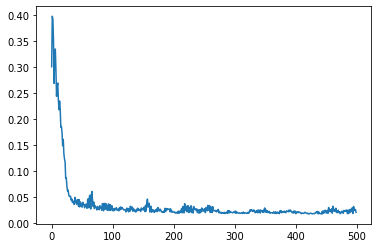

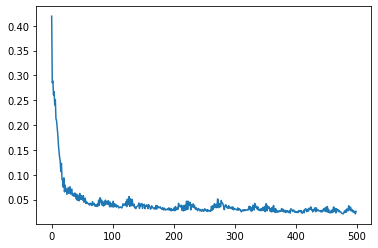

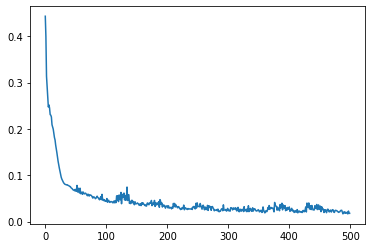

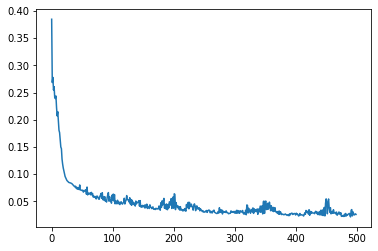

Test Results for 1 test sample(s):



Cases     Predicted
Country_Region Province_State weekday Date                             
Canada                        5       2021-01-22  41730.0  37141.750000
                                      2021-01-29  33384.0  36672.484375
                                      2021-02-05  26878.0  28241.648438
                                      2021-02-12  22081.0  33653.441406

4-week ahead prediction MAPE is 52.409%


In [16]:
models = train(df_train_scaled)
test(df_test, df_test_scaled, models)